In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
from scipy import stats

In [2]:
caminho_arquivo = './dados/MICRODADOS_ENEM_2023.csv'
data = pd.read_csv(caminho_arquivo, encoding='latin1', sep=';')
num_columns = data.shape[1]
num_rows = data.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
data.head()

Número de colunas: 76
Número de linhas: 3933955


,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,210059085136,2023,14,M,2,1,1,1,17,1,...,C,C,B,B,A,B,B,A,A,B
1,210059527735,2023,12,M,2,1,0,1,16,1,...,B,A,B,B,A,A,C,A,D,B
2,210061103945,2023,6,F,1,1,1,1,0,1,...,B,A,A,B,A,A,A,A,A,B
3,210060214087,2023,2,F,1,3,1,2,0,2,...,A,A,A,B,A,A,D,A,A,B
4,210059980948,2023,3,F,1,3,1,2,0,2,...,A,A,A,B,A,A,B,A,A,A


In [3]:
#função tratar nulos
def tratarNulos(dados):
    dataset = dados.copy()  # evita problemas de referência
    
    # Colunas numéricas que representam categorias
    colunas_categoricas_numericas = [
        'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
        'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
        'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC','Q006',
        'Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019'
    ]
    
    for col in dataset.columns:
        if dataset[col].isnull().any():  # só trata se houver nulos
            if col in colunas_categoricas_numericas:
                # Para categóricas → moda
                moda = dataset[col].mode()
                if not moda.empty:
                    dataset[col] = dataset[col].fillna(moda.iloc[0])
            else:
                # Para numéricas contínuas → média
                media = dataset[col].mean()
                dataset[col] = dataset[col].fillna(media)
    
    return dataset

In [4]:
dados_selecionados = data[['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO','Q006', 'Q007','Q008','Q009','Q010','Q011',
                       'Q012','Q013','Q014','Q015','Q016',
                       'Q017','Q018','Q019']]

In [5]:
print("Antes:")
print(dados_selecionados.isnull().sum()[data.isnull().sum() > 0])
dataset_sem_nulos  = tratarNulos(dados_selecionados)
print("\nDepois:")
print(dataset_sem_nulos.isnull().sum()[dataset_sem_nulos.isnull().sum() > 0])

Antes:
TP_ENSINO             2594874
TP_LOCALIZACAO_ESC    2975449
NU_NOTA_CN            1241528
NU_NOTA_CH            1111312
NU_NOTA_LC            1111312
NU_NOTA_MT            1241528
NU_NOTA_REDACAO       1111312
dtype: int64

Depois:
Series([], dtype: int64)


In [6]:
# Dicionário para mapear as respostas da questão Q006 (faixa de renda) em classes sociais
mapa_renda = {
    'A': 'Até 2 salários mínimos',
    'B': 'Até 2 salários mínimos',
    'C': 'Até 2 salários mínimos',
    'D': 'Até 2 salários mínimos',
    'E': 'De 2 a 3 salários mínimos',
    'F': 'De 3 a 6 salários mínimos',
    'G': 'De 3 a 6 salários mínimos',
    'H': 'De 3 a 6 salários mínimos',
    'I': 'De 3 a 6 salários mínimos',
    'J': 'De 3 a 6 salários mínimos',
    'K': 'De 6 a 10 salários mínimos',
    'L': 'De 6 a 10 salários mínimos',
    'M': 'De 6 a 10 salários mínimos',
    'N': 'De 6 a 10 salários mínimos',
    'O': 'De 10 a 15 salários mínimos',
    'P': 'De 10 a 15 salários mínimos',
    'Q': 'Acima de 15 salários mínimos'
}

# Criar nova coluna 'classe_social' baseada na resposta da questão Q006
dataset_sem_nulos['classe_social'] = dataset_sem_nulos['Q006'].map(mapa_renda)
dataset_sem_nulos = dataset_sem_nulos.drop(columns=['Q006'])

In [7]:
num_columns = dataset_sem_nulos.shape[1]
num_rows = dataset_sem_nulos.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
dataset_sem_nulos.head()

Número de colunas: 29
Número de linhas: 3933955


,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_LOCALIZACAO_ESC,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,classe_social
0,14,M,2,1,1,1,17,1,1.0,1.0,...,D,C,B,B,D,C,C,B,B,De 3 a 6 salários mínimos
1,12,M,2,1,0,1,16,1,1.0,1.0,...,A,B,B,B,A,B,A,B,B,De 3 a 6 salários mínimos
2,6,F,1,1,1,1,0,1,1.0,1.0,...,A,B,A,B,A,B,A,A,B,Até 2 salários mínimos
3,2,F,1,3,1,2,0,2,1.0,1.0,...,A,B,A,A,A,A,A,A,B,Até 2 salários mínimos
4,3,F,1,3,1,2,0,2,1.0,1.0,...,A,B,A,A,A,A,A,A,B,Até 2 salários mínimos


In [8]:
# 1. Separar X e y
X = dataset_sem_nulos.drop(columns=['classe_social'])
y = dataset_sem_nulos['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('classificador', clf) 
])



# 6. Treinar modelo
modelo.fit(X, y)

# 7. Avaliar
y_pred = modelo.predict(X)
print("Acurácia:", accuracy_score(y, y_pred))
print("\nRelatório de classificação:\n", classification_report(y, y_pred))
print("\nMatriz de confusão:\n", confusion_matrix(y, y_pred))


Acurácia: 0.9759232121363869

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      1.00      0.99     51489
      Até 2 salários mínimos       0.97      1.00      0.98   2601632
 De 10 a 15 salários mínimos       0.99      0.99      0.99     79323
   De 2 a 3 salários mínimos       0.98      0.87      0.93    293994
   De 3 a 6 salários mínimos       0.98      0.94      0.96    733099
  De 6 a 10 salários mínimos       1.00      0.97      0.98    174418

                    accuracy                           0.98   3933955
                   macro avg       0.99      0.96      0.97   3933955
                weighted avg       0.98      0.98      0.98   3933955


Matriz de confusão:
 [[  51299      68      13       5      88      16]
 [     62 2595135       8     982    5397      48]
 [    156     529   78215      25     353      45]
 [     26   34264      81  256664    2931      28]
 [    171   

In [9]:
def analisar_importancia_features_agregada(modelo, clf, categoricas, top_n=None):
    """
    Exibe a importância das features de um modelo DecisionTreeClassifier,
    somando as importâncias das dummies das features categóricas.

    Parâmetros:
    - modelo: pipeline treinado (com preprocessador + classificador)
    - clf: classificador treinado (ex: DecisionTreeClassifier)
    - categoricas: lista de colunas categóricas originais
    - top_n: se quiser mostrar só as N variáveis mais importantes (opcional)

    Retorna:
    - df_agregado: DataFrame com importância agregada por feature
    """

    # Extrair nomes das features pós-transformação
    nomes_features = modelo.named_steps['preprocessador'].get_feature_names_out()
    
    # Importâncias
    importances = clf.feature_importances_
    
    # Criar DataFrame
    df = pd.DataFrame({
        'feature_expandida': nomes_features,
        'importancia': importances
    })
    
    # Inicializar coluna de feature original
    df['feature_original'] = df['feature_expandida']
    
    # Mapear dummies categóricas para a feature original
    for cat in categoricas:
        mask = df['feature_expandida'].str.contains(f"__{cat}_")
        df.loc[mask, 'feature_original'] = cat
    
    # Agregar importâncias por feature original
    df_agregado = df.groupby('feature_original')['importancia'].sum().sort_values(ascending=False)
    
    # Filtrar top_n se necessário
    if top_n:
        df_agregado = df_agregado.head(top_n)
    
    # Print em texto
    print("Importância das features (agregada):")
    for feat, imp in df_agregado.items():
        print(f"Feature {feat}: {imp:.4f}")
    
    # Gráfico
    plt.figure(figsize=(10,6))
    plt.bar(range(len(df_agregado)), df_agregado.values, align="center")
    plt.xticks(range(len(df_agregado)), df_agregado.index, rotation=90)
    plt.title("Importância das Features (DecisionTreeClassifier)")
    plt.tight_layout()
    plt.show()
    
    return df_agregado

In [10]:
def analisar_importancia_features(modelo, clf, top_n=None):
    """
    Exibe a importância individual das features (sem agregação) 
    de um modelo DecisionTreeClassifier treinado dentro de um pipeline.

    Parâmetros:
    - modelo: pipeline treinado (com preprocessador + classificador)
    - clf: classificador treinado (ex: DecisionTreeClassifier)
    - top_n: se quiser mostrar só as N variáveis mais importantes (opcional)

    Retorna:
    - df_importancias: DataFrame com importâncias individuais
    """

    # Extrair nomes das features após o pré-processamento
    nomes_features = modelo.named_steps['preprocessador'].get_feature_names_out()

    # Pegar as importâncias
    importances = clf.feature_importances_

    # Criar DataFrame
    df_importancias = pd.DataFrame({
        'feature': nomes_features,
        'importancia': importances
    }).sort_values(by='importancia', ascending=False)

    # Filtrar top_n se solicitado
    if top_n:
        df_importancias = df_importancias.head(top_n)

    # Print simples
    print("Importância das features (sem agregação):")
    for feat, imp in zip(df_importancias['feature'], df_importancias['importancia']):
        print(f"{feat}: {imp:.4f}")

    # Gráfico
    plt.figure(figsize=(10,6))
    plt.barh(df_importancias['feature'], df_importancias['importancia'])
    plt.xlabel("Importância")
    plt.ylabel("Feature")
    plt.title("Importância Individual das Features (DecisionTreeClassifier)")
    plt.gca().invert_yaxis()  # deixa a mais importante no topo
    plt.tight_layout()
    plt.show()

    return df_importancias

In [65]:
def analisar_desempenho_por_classe(dataset, nome_dataset, notas=['NU_NOTA_CH','NU_NOTA_CN','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO']):
    """
    Analisa estatísticas das notas por classe social, incluindo média, mediana, 
    desvio padrão, variância, amplitude e coeficiente de variação.
    Garante ordenação correta das classes mesmo que haja variações de texto.
    """

    # Criar coluna de média das notas
    dataset['media_notas'] = dataset[notas].mean(axis=1)

    # Funções auxiliares
    def calc_amplitude(x):
        return x.max() - x.min()

    def calc_cv(x):
        return (x.std() / x.mean()) * 100 if x.mean() != 0 else np.nan

    # Agrupar por classe social
    resumo = dataset.groupby('classe_social')['media_notas'].agg(
        media='mean',
        mediana='median',
        desvio_padrao='std',
        variancia='var',
        q1=lambda x: np.percentile(x, 25),
        q3=lambda x: np.percentile(x, 75),
        valor_minimo='min',
        valor_maximo='max',
        amplitude=calc_amplitude,
        coef_var=calc_cv
    ).reset_index()

    # Dicionário para garantir ordem correta das classes
    ordem_classes = {
        "Até 2 salários mínimos": 1,
        "De 2 a 3 salários mínimos": 2,
        "De 3 a 6 salários mínimos": 3,
        "De 6 a 10 salários mínimos": 4,
        "De 10 a 15 salários mínimos": 5,
        "Acima de 15 salários mínimos": 6
    }

    # Mapeamento seguro: procurar substring correspondente
    def mapear_ordem(classe):
        for nome, ordem in ordem_classes.items():
            if nome in classe:
                return ordem
        return np.nan  # caso alguma classe não bata exatamente

    resumo['ordem'] = resumo['classe_social'].apply(mapear_ordem)

    # Ordenar de fato
    resumo = resumo.sort_values('ordem')

    # Imprimir tabela
    print(f"\nResumo estatístico completo por classe social {nome_dataset}:")
    print(resumo[['classe_social', 'media', 'mediana', 'desvio_padrao', 
                  'variancia', 'q1', 'q3', 'valor_minimo', 'valor_maximo', 
                  'amplitude', 'coef_var']].to_string(index=False))

    # Gráfico: média ± desvio padrão
    plt.figure(figsize=(12,6))
    plt.bar(resumo['classe_social'], resumo['media'], 
            yerr=resumo['desvio_padrao'], capsize=5, color='skyblue')
    plt.xlabel("Classe Social")
    plt.ylabel("Média das notas")
    plt.title(f"Média e Desvio Padrão das Notas por Classe Social {nome_dataset}")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

    return resumo

Importância das features (agregada):
Feature Q010: 0.1866
Feature num__NU_NOTA_MT: 0.1005
Feature num__NU_NOTA_LC: 0.0898
Feature num__NU_NOTA_CH: 0.0891
Feature num__NU_NOTA_CN: 0.0862
Feature num__NU_NOTA_REDACAO: 0.0607
Feature Q008: 0.0543
Feature num__TP_FAIXA_ETARIA: 0.0420
Feature Q018: 0.0279
Feature num__TP_COR_RACA: 0.0255
Feature num__TP_ANO_CONCLUIU: 0.0253
Feature Q009: 0.0234
Feature Q011: 0.0219
Feature Q013: 0.0204
Feature Q019: 0.0203
Feature Q007: 0.0201
Feature Q014: 0.0166
Feature TP_SEXO: 0.0155
Feature num__TP_ESTADO_CIVIL: 0.0130
Feature Q015: 0.0129


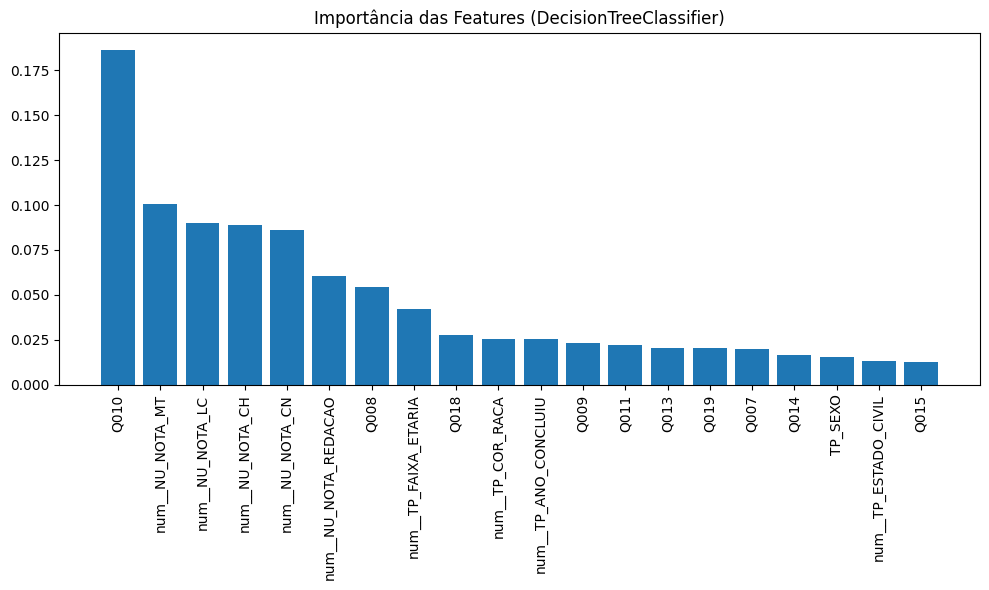

In [12]:
df_importancia = analisar_importancia_features_agregada(modelo, clf, categoricas, 20)


Importância das features (sem agregação):
cat__Q010_A: 0.1786
num__NU_NOTA_MT: 0.1005
num__NU_NOTA_LC: 0.0898
num__NU_NOTA_CH: 0.0891
num__NU_NOTA_CN: 0.0862
num__NU_NOTA_REDACAO: 0.0607
cat__Q008_B: 0.0454
num__TP_FAIXA_ETARIA: 0.0420
num__TP_COR_RACA: 0.0255
num__TP_ANO_CONCLUIU: 0.0253
cat__Q018_A: 0.0165
cat__Q007_A: 0.0159
num__TP_ESTADO_CIVIL: 0.0130
cat__Q014_A: 0.0129
cat__Q018_B: 0.0114


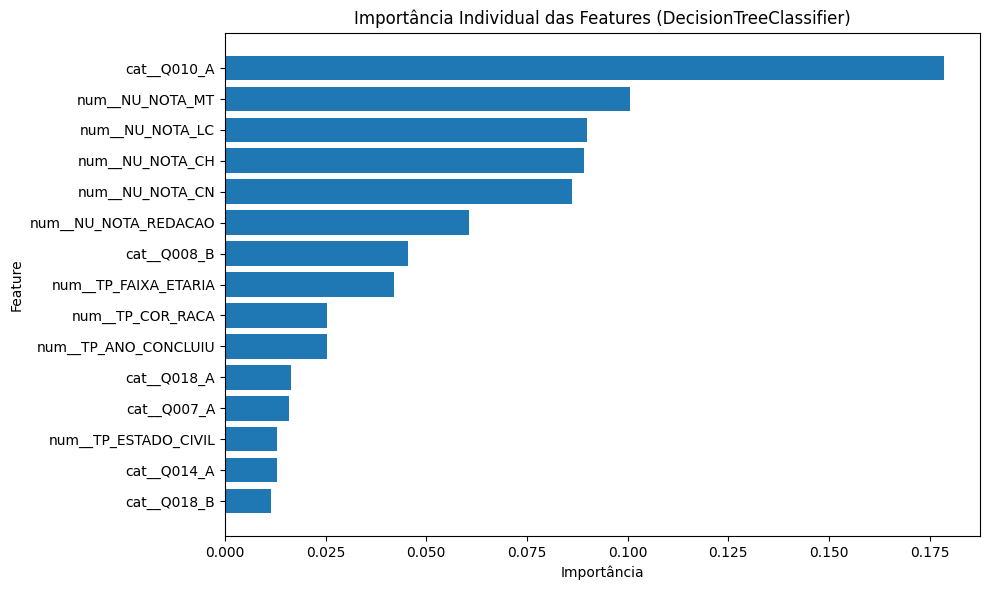

In [13]:
df_importancias_individuais = analisar_importancia_features(modelo, clf, top_n=15)



Resumo estatístico completo por classe social geral:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 518.209141 537.777315      71.151907 5062.593873 481.500000 537.777315          0.00        847.54     847.54 13.730346
   De 2 a 3 salários mínimos 547.516598 537.777315      74.421623 5538.578001 515.480000 587.840000          0.00        836.80     836.80 13.592578
   De 3 a 6 salários mínimos 572.332019 557.360000      81.027562 6565.465800 537.777315 627.280000          0.00        862.58     862.58 14.157440
  De 6 a 10 salários mínimos 604.964499 605.418725      85.049628 7233.439202 537.777315 668.115000          0.00        847.26     847.26 14.058615
 De 10 a 15 salários mínimos 619.950986 624.880000      85.593298 7326.212653 542.600000 684.520000        107.90        844.70     736.80 13.806462
Acima de 15 salários mínimos 624.727161 631.860000  

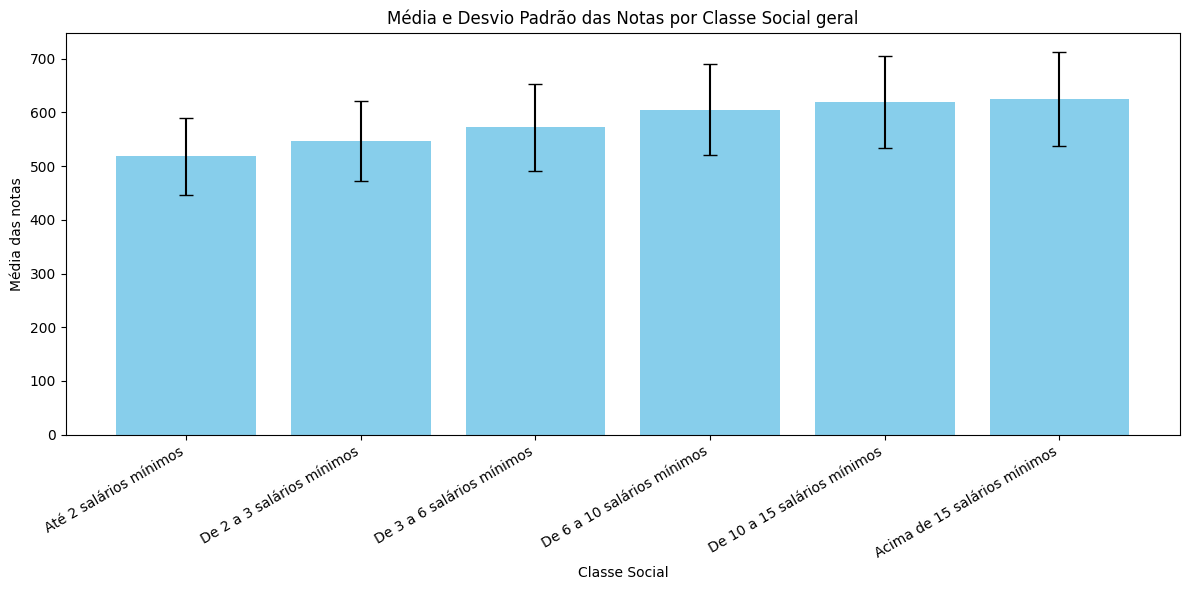

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,518.209141,537.777315,71.151907,5062.593873,481.500000,537.777315,0.00,847.54,847.54,13.730346,1
3,De 2 a 3 salários mínimos,547.516598,537.777315,74.421623,5538.578001,515.480000,587.840000,0.00,836.80,836.80,13.592578,2
4,De 3 a 6 salários mínimos,572.332019,557.360000,81.027562,6565.465800,537.777315,627.280000,0.00,862.58,862.58,14.157440,3
5,De 6 a 10 salários mínimos,604.964499,605.418725,85.049628,7233.439202,537.777315,668.115000,0.00,847.26,847.26,14.058615,4
2,De 10 a 15 salários mínimos,619.950986,624.880000,85.593298,7326.212653,542.600000,684.520000,107.90,844.70,736.80,13.806462,5
0,Acima de 15 salários mínimos,624.727161,631.860000,87.895092,7725.547248,543.200000,691.700000,57.88,850.40,792.52,14.069357,6


In [66]:
analisar_desempenho_por_classe(dataset_sem_nulos, "geral")

In [15]:
# Filtrar apenas escolas urbanas
dataset_urbano = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 1]

# Filtrar apenas escolas rurais
dataset_rural = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 2]

In [32]:
# 1. Separar X e y
X_urbano = dataset_urbano.drop(columns=['classe_social'])
y_urbano = dataset_urbano['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_urbano = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_urbano = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_urbano = Pipeline(steps=[
    ('preprocessador', preprocessador_urbano),
    ('classificador', clf_urbano) 
])



# 6. Treinar modelo
modelo_urbano.fit(X_urbano, y_urbano)

# 7. Avaliar
y_pred_urbano = modelo_urbano.predict(X_urbano)
print("Acurácia:", accuracy_score(y_urbano, y_pred_urbano))
print("\nRelatório de classificação:\n", classification_report(y_urbano, y_pred_urbano))
print("\nMatriz de confusão:\n", confusion_matrix(y_urbano, y_pred_urbano))


Acurácia: 0.9757440733857408

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      1.00      0.99     51421
      Até 2 salários mínimos       0.97      1.00      0.98   2572953
 De 10 a 15 salários mínimos       0.99      0.99      0.99     79174
   De 2 a 3 salários mínimos       0.98      0.87      0.92    291943
   De 3 a 6 salários mínimos       0.98      0.94      0.96    728953
  De 6 a 10 salários mínimos       1.00      0.97      0.98    173861

                    accuracy                           0.98   3898305
                   macro avg       0.99      0.96      0.97   3898305
                weighted avg       0.98      0.98      0.98   3898305


Matriz de confusão:
 [[  51231      68      13       5      88      16]
 [     62 2566460       8     979    5396      48]
 [    156     528   78067      25     353      45]
 [     26   34191      81  254686    2931      28]
 [    171   

C:\Users\Carlos\AppData\Local\Temp\ipykernel_7252\3947054212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social de alunos do meio urbano:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 518.383721 537.777315      71.046949 5047.668953 481.780000 537.777315          0.00        847.54     847.54 13.705475
   De 2 a 3 salários mínimos 547.609059 537.777315      74.391194 5534.049726 515.660000 587.900000          0.00        836.80     836.80 13.584727
   De 3 a 6 salários mínimos 572.406316 557.400000      81.021302 6564.451392 537.777315 627.340000          0.00        862.58     862.58 14.154509
  De 6 a 10 salários mínimos 605.017668 605.460000      85.060937 7235.362978 537.777315 668.200000          0.00        847.26     847.26 14.059248
 De 10 a 15 salários mínimos 620.008815 624.920000      85.591235 7325.859558 542.660000 684.560000        107.90        844.70     736.80 13.804842
Acima de 15 salários mínimos 624.

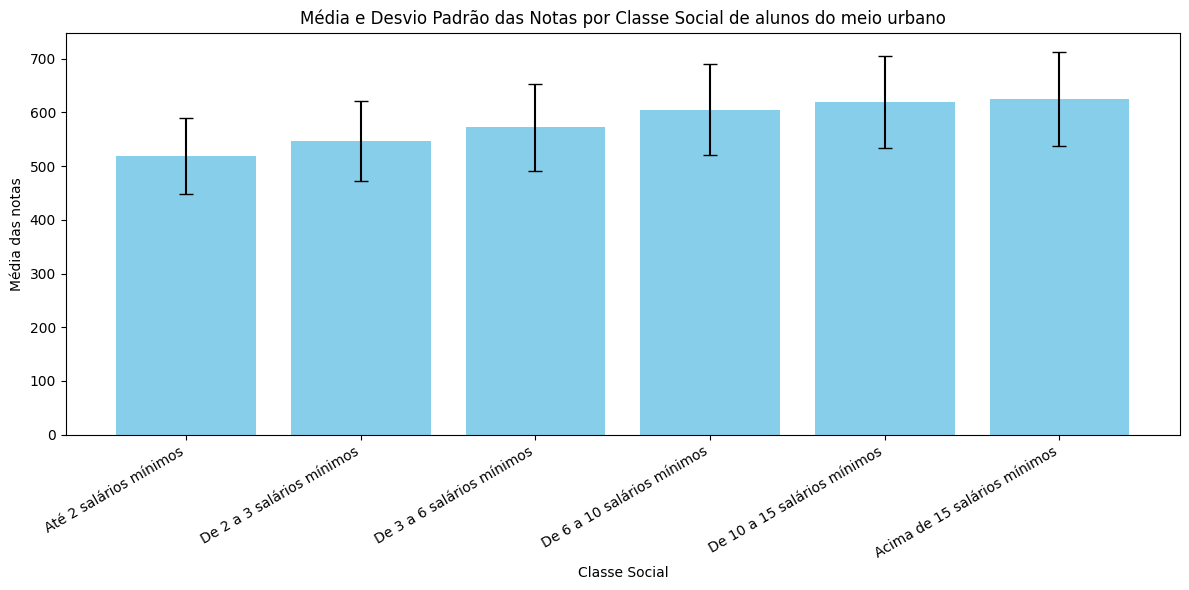

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,518.383721,537.777315,71.046949,5047.668953,481.780000,537.777315,0.00,847.54,847.54,13.705475,1
3,De 2 a 3 salários mínimos,547.609059,537.777315,74.391194,5534.049726,515.660000,587.900000,0.00,836.80,836.80,13.584727,2
4,De 3 a 6 salários mínimos,572.406316,557.400000,81.021302,6564.451392,537.777315,627.340000,0.00,862.58,862.58,14.154509,3
5,De 6 a 10 salários mínimos,605.017668,605.460000,85.060937,7235.362978,537.777315,668.200000,0.00,847.26,847.26,14.059248,4
2,De 10 a 15 salários mínimos,620.008815,624.920000,85.591235,7325.859558,542.660000,684.560000,107.90,844.70,736.80,13.804842,5
0,Acima de 15 salários mínimos,624.830056,631.980000,87.856635,7718.788346,543.499865,691.740000,57.88,850.40,792.52,14.060885,6


In [67]:
analisar_desempenho_por_classe(dataset_urbano, "de alunos do meio urbano")

Importância das features (agregada):
Feature Q010: 0.1866
Feature num__NU_NOTA_MT: 0.1010
Feature num__NU_NOTA_LC: 0.0898
Feature num__NU_NOTA_CH: 0.0892
Feature num__NU_NOTA_CN: 0.0863
Feature num__NU_NOTA_REDACAO: 0.0607
Feature Q008: 0.0542
Feature num__TP_FAIXA_ETARIA: 0.0422
Feature Q018: 0.0279
Feature num__TP_COR_RACA: 0.0255
Feature num__TP_ANO_CONCLUIU: 0.0253
Feature Q009: 0.0232
Feature Q011: 0.0217
Feature Q019: 0.0206
Feature Q013: 0.0203
Feature Q007: 0.0201
Feature Q014: 0.0166
Feature TP_SEXO: 0.0156
Feature Q015: 0.0131
Feature num__TP_ESTADO_CIVIL: 0.0130


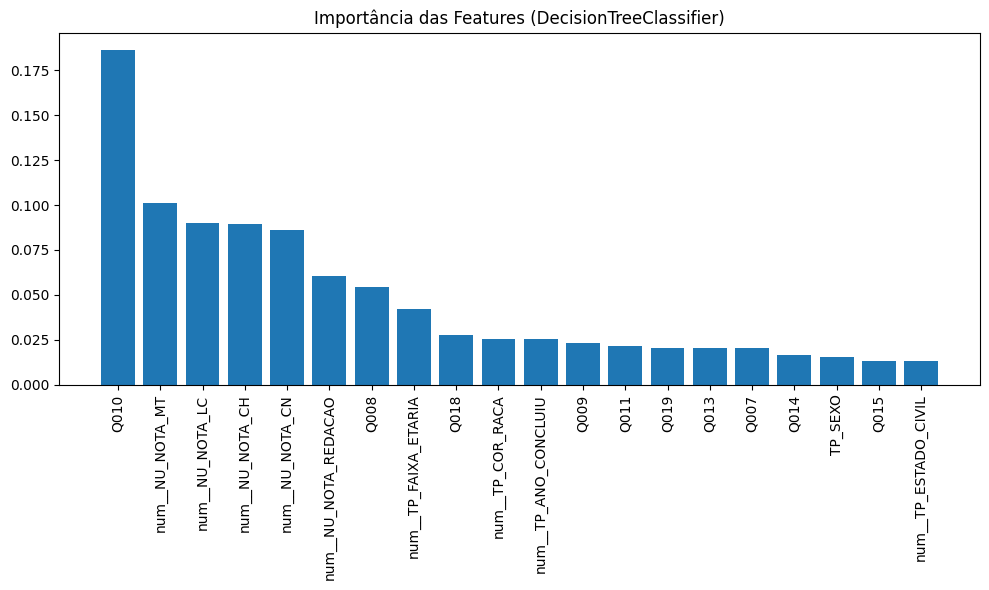

In [34]:
df_importancia_urbano = analisar_importancia_features_agregada(modelo_urbano, clf_urbano, categoricas, 20)

Importância das features (sem agregação):
cat__Q010_A: 0.1786
num__NU_NOTA_MT: 0.1010
num__NU_NOTA_LC: 0.0898
num__NU_NOTA_CH: 0.0892
num__NU_NOTA_CN: 0.0863
num__NU_NOTA_REDACAO: 0.0607
cat__Q008_B: 0.0453
num__TP_FAIXA_ETARIA: 0.0422
num__TP_COR_RACA: 0.0255
num__TP_ANO_CONCLUIU: 0.0253
cat__Q018_B: 0.0175
cat__Q007_A: 0.0159
num__TP_ESTADO_CIVIL: 0.0130
cat__Q014_A: 0.0128
cat__Q018_A: 0.0104


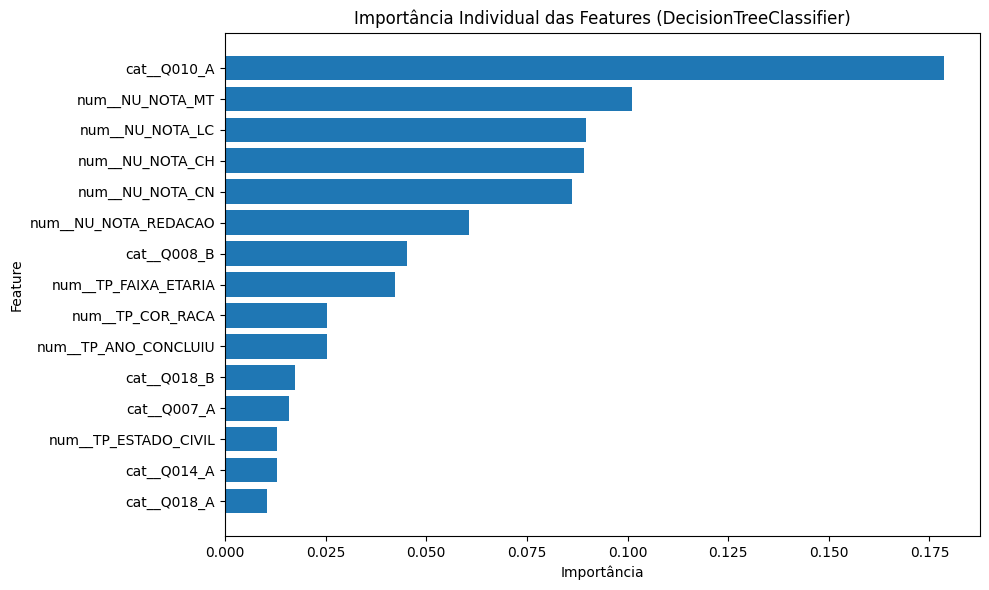

In [35]:
df_importancias_individuais_urbano = analisar_importancia_features(modelo_urbano, clf_urbano, top_n=15)

In [36]:
# 1. Separar X e y
X_rural = dataset_rural.drop(columns=['classe_social'])
y_rural = dataset_rural['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_rural = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_rural = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_rural = Pipeline(steps=[
    ('preprocessador', preprocessador_rural),
    ('classificador', clf_rural) 
])



# 6. Treinar modelo
modelo_rural.fit(X_rural, y_rural)

# 7. Avaliar
y_pred_rural = modelo_rural.predict(X_rural)
print("Acurácia:", accuracy_score(y_rural, y_pred_rural))
print("\nRelatório de classificação:\n", classification_report(y_rural, y_pred_rural))
print("\nMatriz de confusão:\n", confusion_matrix(y_rural, y_pred_rural))


Acurácia: 0.9955119214586255

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       1.00      1.00      1.00        68
      Até 2 salários mínimos       0.99      1.00      1.00     28679
 De 10 a 15 salários mínimos       1.00      0.99      1.00       149
   De 2 a 3 salários mínimos       1.00      0.96      0.98      2051
   De 3 a 6 salários mínimos       1.00      0.98      0.99      4146
  De 6 a 10 salários mínimos       1.00      1.00      1.00       557

                    accuracy                           1.00     35650
                   macro avg       1.00      0.99      0.99     35650
                weighted avg       1.00      1.00      1.00     35650


Matriz de confusão:
 [[   68     0     0     0     0     0]
 [    0 28675     0     3     1     0]
 [    0     1   148     0     0     0]
 [    0    73     0  1978     0     0]
 [    0    74     0     6  4066     0]
 [    0     1     0  


Resumo estatístico completo por classe social de alunos do meio rural:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 502.546582 537.777315      78.445877 6153.755632 455.560000 537.777315     132.00000        753.90  621.90000 15.609673
   De 2 a 3 salários mínimos 534.355512 537.777315      77.534757 6011.638511 491.260000 578.550000     147.18000        781.42  634.24000 14.509957
   De 3 a 6 salários mínimos 559.269009 551.870000      81.078927 6573.792393 518.510000 615.110000     143.70000        824.62  680.92000 14.497304
  De 6 a 10 salários mínimos 588.368252 592.980000      79.800210 6368.073533 537.777315 646.980000     330.46000        794.14  463.68000 13.562970
 De 10 a 15 salários mínimos 589.222748 589.840000      81.315495 6612.209791 537.777315 652.580000     313.30000        785.90  472.60000 13.800468
Acima de 15 salários mínimos 546.9

C:\Users\Carlos\AppData\Local\Temp\ipykernel_7252\3947054212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)


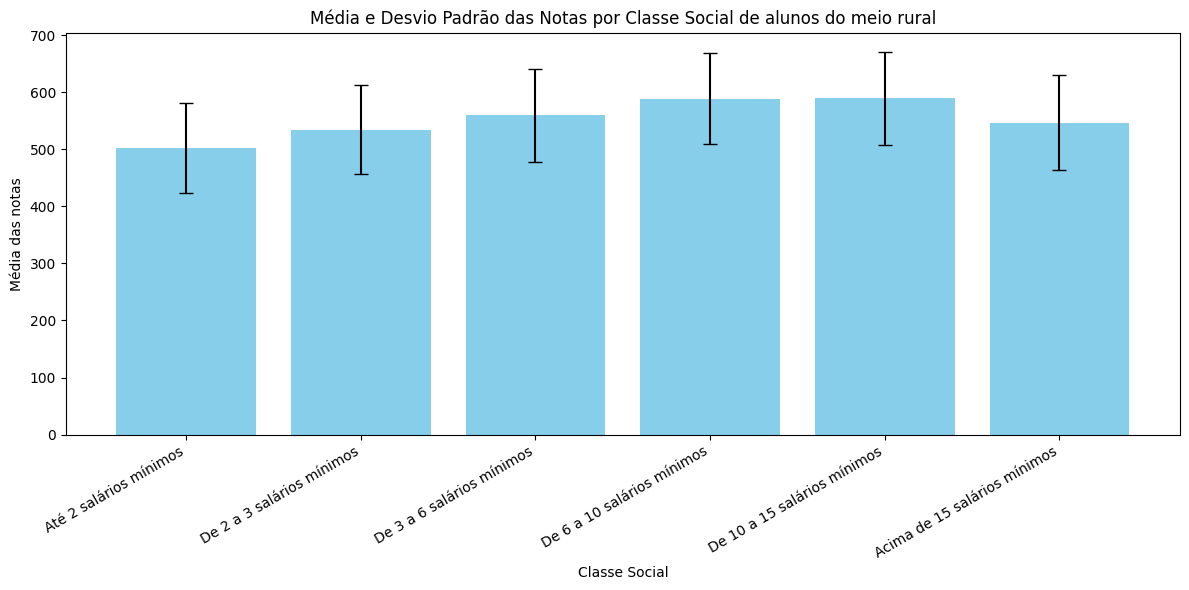

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,502.546582,537.777315,78.445877,6153.755632,455.560000,537.777315,132.00000,753.90,621.90000,15.609673,1
3,De 2 a 3 salários mínimos,534.355512,537.777315,77.534757,6011.638511,491.260000,578.550000,147.18000,781.42,634.24000,14.509957,2
4,De 3 a 6 salários mínimos,559.269009,551.870000,81.078927,6573.792393,518.510000,615.110000,143.70000,824.62,680.92000,14.497304,3
5,De 6 a 10 salários mínimos,588.368252,592.980000,79.800210,6368.073533,537.777315,646.980000,330.46000,794.14,463.68000,13.562970,4
2,De 10 a 15 salários mínimos,589.222748,589.840000,81.315495,6612.209791,537.777315,652.580000,313.30000,785.90,472.60000,13.800468,5
0,Acima de 15 salários mínimos,546.919173,537.777315,82.918582,6875.491272,506.325000,591.965000,364.73745,751.44,386.70255,15.161030,6


In [68]:
analisar_desempenho_por_classe(dataset_rural, "de alunos do meio rural")

Importância das features (agregada):
Feature Q010: 0.1737
Feature num__NU_NOTA_MT: 0.1015
Feature num__NU_NOTA_CH: 0.0916
Feature num__NU_NOTA_LC: 0.0880
Feature num__NU_NOTA_CN: 0.0851
Feature num__NU_NOTA_REDACAO: 0.0606
Feature Q008: 0.0567
Feature Q011: 0.0390
Feature Q009: 0.0354
Feature num__TP_FAIXA_ETARIA: 0.0316
Feature num__TP_COR_RACA: 0.0309
Feature Q019: 0.0305
Feature Q013: 0.0255
Feature Q014: 0.0251
Feature TP_SEXO: 0.0209
Feature Q016: 0.0183
Feature Q015: 0.0167
Feature Q018: 0.0163
Feature Q012: 0.0133
Feature Q007: 0.0117


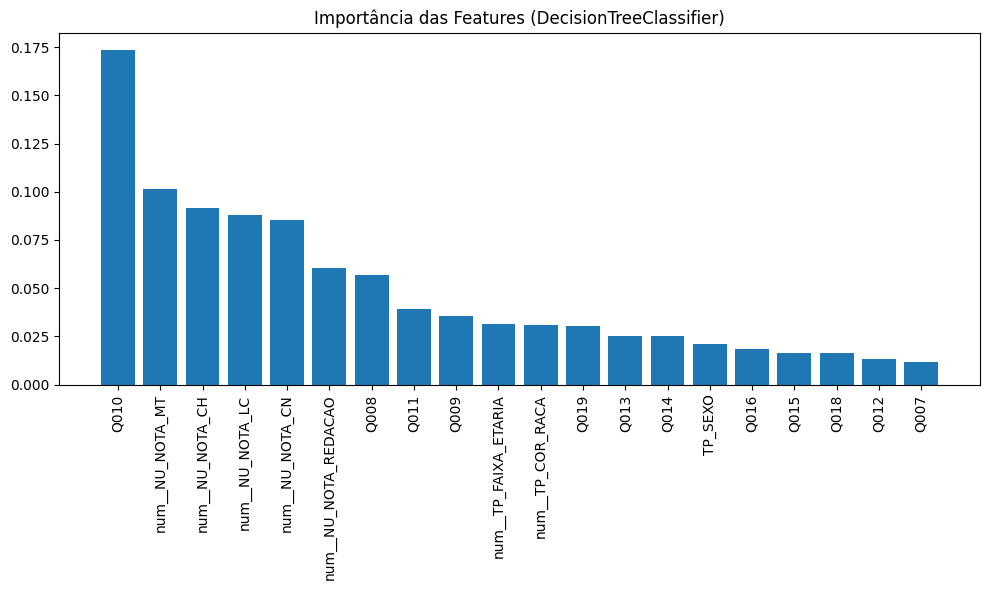

In [38]:
df_importancia_rural = analisar_importancia_features_agregada(modelo_rural,clf_rural, categoricas, top_n=20)

Importância das features (sem agregação):
cat__Q010_A: 0.1609
num__NU_NOTA_MT: 0.1015
num__NU_NOTA_CH: 0.0916
num__NU_NOTA_LC: 0.0880
num__NU_NOTA_CN: 0.0851
num__NU_NOTA_REDACAO: 0.0606
cat__Q008_B: 0.0454
num__TP_FAIXA_ETARIA: 0.0316
num__TP_COR_RACA: 0.0309
cat__Q014_A: 0.0194
cat__Q009_D: 0.0139
cat__Q011_A: 0.0135
cat__Q011_B: 0.0124
cat__Q009_C: 0.0112
cat__TP_SEXO_F: 0.0111


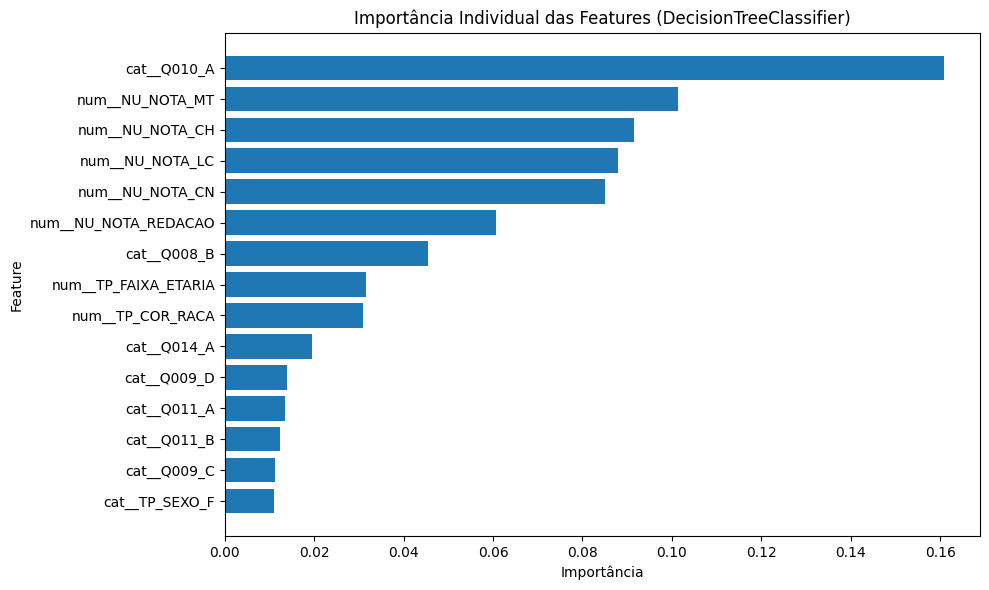

In [39]:
df_importancias_individuais_rural = analisar_importancia_features(modelo_rural, clf_rural, top_n=15)

In [40]:
# Filtrar apenas homens
dataset_homem = dataset_sem_nulos[dataset_sem_nulos['TP_SEXO'] == "M"]

# Filtrar apenas mulheres
dataset_mulher = dataset_sem_nulos[dataset_sem_nulos['TP_SEXO'] == "F"]

In [41]:
# 1. Separar X e y
X_homem = dataset_homem.drop(columns=['classe_social'])
y_homem = dataset_homem['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_homem = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_homem = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_homem = Pipeline(steps=[
    ('preprocessador', preprocessador_homem),
    ('classificador', clf_homem) 
])



# 6. Treinar modelo
modelo_homem.fit(X_homem, y_homem)

# 7. Avaliar
y_pred_homem = modelo_homem.predict(X_homem)
print("Acurácia:", accuracy_score(y_homem, y_pred_homem))
print("\nRelatório de classificação:\n", classification_report(y_homem, y_pred_homem))
print("\nMatriz de confusão:\n", confusion_matrix(y_homem, y_pred_homem))

Acurácia: 0.9730051156773512

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      1.00      0.99     26345
      Até 2 salários mínimos       0.97      1.00      0.98    926823
 De 10 a 15 salários mínimos       0.99      0.99      0.99     37815
   De 2 a 3 salários mínimos       0.98      0.88      0.93    122236
   De 3 a 6 salários mínimos       0.98      0.94      0.96    328021
  De 6 a 10 salários mínimos       1.00      0.97      0.98     81530

                    accuracy                           0.97   1522770
                   macro avg       0.98      0.96      0.97   1522770
                weighted avg       0.97      0.97      0.97   1522770


Matriz de confusão:
 [[ 26242     39     10      1     45      8]
 [    32 923683      4    428   2654     22]
 [    74    266  37258     12    178     27]
 [    15  13610     40 107100   1457     14]
 [    82  17570    197   1425 308686

Importância das features (agregada):
Feature Q010: 0.1778
Feature num__NU_NOTA_MT: 0.0985
Feature num__NU_NOTA_CH: 0.0888
Feature num__NU_NOTA_LC: 0.0882
Feature num__NU_NOTA_CN: 0.0850
Feature num__NU_NOTA_REDACAO: 0.0619
Feature Q008: 0.0495
Feature num__TP_FAIXA_ETARIA: 0.0474
Feature num__TP_COR_RACA: 0.0295
Feature num__TP_ANO_CONCLUIU: 0.0281
Feature Q009: 0.0266
Feature Q011: 0.0242
Feature Q019: 0.0233
Feature Q013: 0.0226
Feature Q007: 0.0224
Feature Q018: 0.0219
Feature Q014: 0.0217
Feature Q015: 0.0146
Feature num__TP_ESTADO_CIVIL: 0.0145
Feature Q016: 0.0143


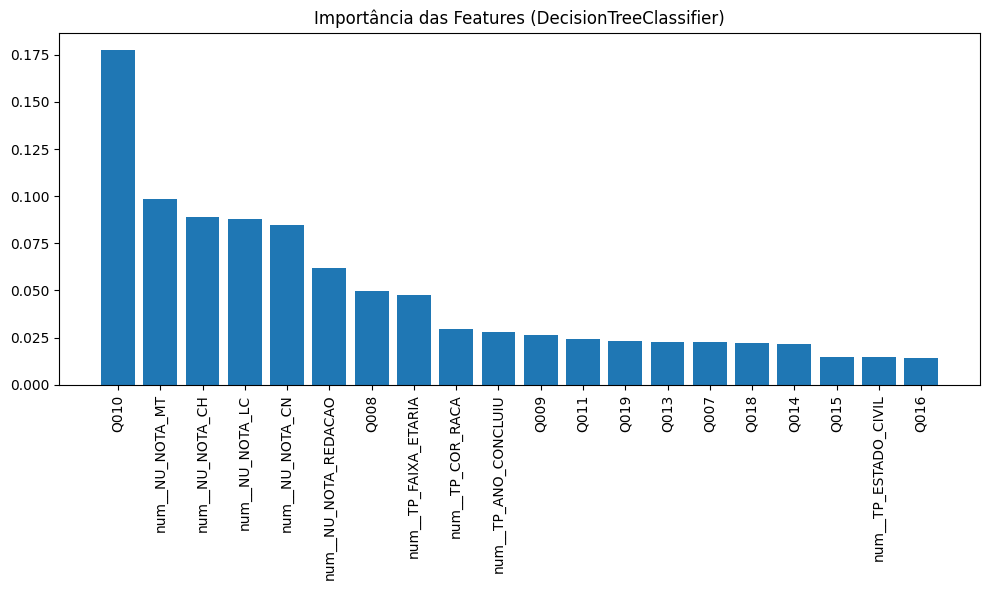

In [69]:
df_importancia_homem = analisar_importancia_features_agregada(modelo_homem, clf_homem, categoricas, 20)

Importância das features (sem agregação):
cat__Q010_A: 0.1691
num__NU_NOTA_MT: 0.0985
num__NU_NOTA_CH: 0.0888
num__NU_NOTA_LC: 0.0882
num__NU_NOTA_CN: 0.0850
num__NU_NOTA_REDACAO: 0.0619
num__TP_FAIXA_ETARIA: 0.0474
cat__Q008_B: 0.0391
num__TP_COR_RACA: 0.0295
num__TP_ANO_CONCLUIU: 0.0281
cat__Q018_A: 0.0214
cat__Q014_A: 0.0172
cat__Q007_A: 0.0172
num__TP_ESTADO_CIVIL: 0.0145
cat__Q011_A: 0.0095


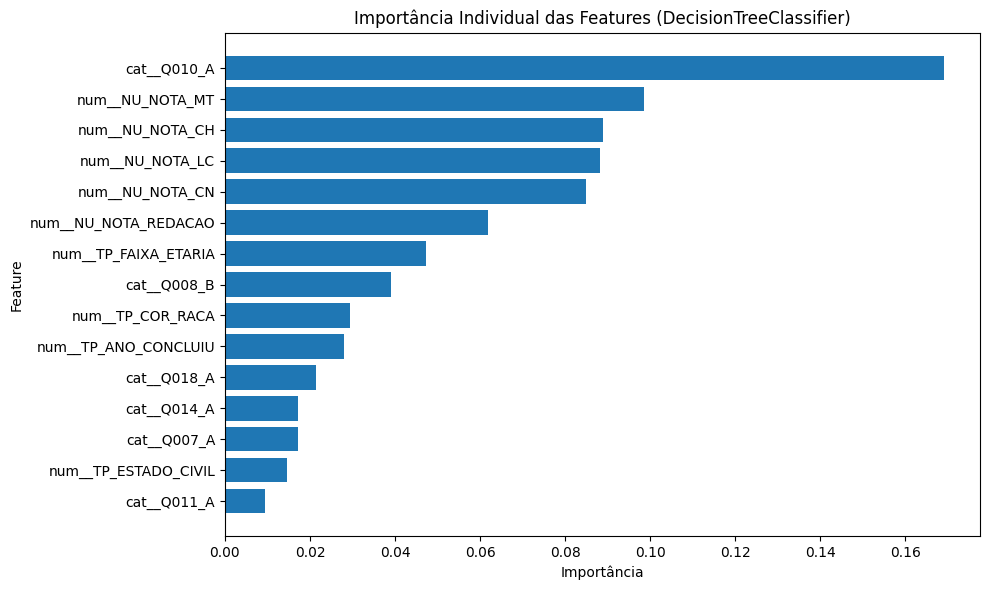

In [43]:
df_importancias_individuais_homem = analisar_importancia_features(modelo_homem, clf_homem, top_n=15)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_7252\3947054212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social de alunos do sexo masculino:
               classe_social      media    mediana  desvio_padrao   variancia         q1     q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 519.535920 537.777315      74.742969 5586.511489 483.620000 540.24          0.00        847.54     847.54 14.386487
   De 2 a 3 salários mínimos 544.953050 537.777315      76.181452 5803.613633 514.760000 584.46          0.00        827.90     827.90 13.979452
   De 3 a 6 salários mínimos 567.432152 548.160000      82.267139 6767.882235 535.660000 621.22          0.00        862.58     862.58 14.498146
  De 6 a 10 salários mínimos 599.723200 597.600000      87.532071 7661.863481 537.777315 664.52          0.00        847.26     847.26 14.595412
 De 10 a 15 salários mínimos 616.074253 619.300000      88.499522 7832.165326 537.777315 682.54        107.90        844.70     736.80 14.365074
Acima de 15 salários mínimos 622.174698 627.880000    

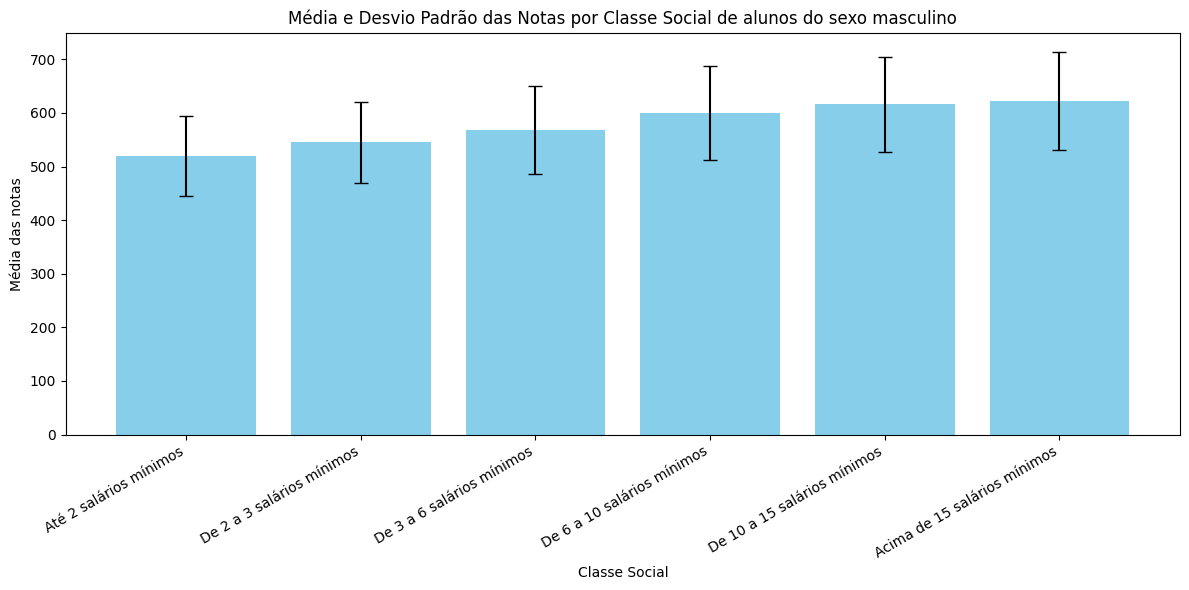

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,519.535920,537.777315,74.742969,5586.511489,483.620000,540.24,0.00,847.54,847.54,14.386487,1
3,De 2 a 3 salários mínimos,544.953050,537.777315,76.181452,5803.613633,514.760000,584.46,0.00,827.90,827.90,13.979452,2
4,De 3 a 6 salários mínimos,567.432152,548.160000,82.267139,6767.882235,535.660000,621.22,0.00,862.58,862.58,14.498146,3
5,De 6 a 10 salários mínimos,599.723200,597.600000,87.532071,7661.863481,537.777315,664.52,0.00,847.26,847.26,14.595412,4
2,De 10 a 15 salários mínimos,616.074253,619.300000,88.499522,7832.165326,537.777315,682.54,107.90,844.70,736.80,14.365074,5
0,Acima de 15 salários mínimos,622.174698,627.880000,91.539885,8379.550553,537.777315,692.62,57.88,843.10,785.22,14.712891,6


In [70]:
analisar_desempenho_por_classe(dataset_homem, "de alunos do sexo masculino")

In [45]:
# 1. Separar X e y
X_mulher = dataset_mulher.drop(columns=['classe_social'])
y_mulher = dataset_mulher['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_mulher = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_mulher = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_mulher = Pipeline(steps=[
    ('preprocessador', preprocessador_mulher),
    ('classificador', clf_mulher) 
])



# 6. Treinar modelo
modelo_mulher.fit(X_mulher, y_mulher)

# 7. Avaliar
y_pred_mulher = modelo_mulher.predict(X_mulher)
print("Acurácia:", accuracy_score(y_mulher, y_pred_mulher))
print("\nRelatório de classificação:\n", classification_report(y_mulher, y_pred_mulher))
print("\nMatriz de confusão:\n", confusion_matrix(y_mulher, y_pred_mulher))


Acurácia: 0.9777661191488832

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      1.00      0.99     25144
      Até 2 salários mínimos       0.97      1.00      0.99   1674809
 De 10 a 15 salários mínimos       0.99      0.99      0.99     41508
   De 2 a 3 salários mínimos       0.99      0.87      0.92    171758
   De 3 a 6 salários mínimos       0.99      0.94      0.96    405078
  De 6 a 10 salários mínimos       1.00      0.97      0.98     92888

                    accuracy                           0.98   2411185
                   macro avg       0.99      0.96      0.97   2411185
                weighted avg       0.98      0.98      0.98   2411185


Matriz de confusão:
 [[  25057      29       3       4      43       8]
 [     30 1671452       4     554    2743      26]
 [     82     263   40957      13     175      18]
 [     11   20654      41  149564    1474      14]
 [     89   

C:\Users\Carlos\AppData\Local\Temp\ipykernel_7252\3947054212.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social de alunos do sexo feminino:
               classe_social      media    mediana  desvio_padrao   variancia         q1         q3  valor_minimo  valor_maximo  amplitude  coef_var
      Até 2 salários mínimos 517.474914 537.777315      69.073532 4771.152881 480.480000 537.777315          0.00        826.30     826.30 13.348190
   De 2 a 3 salários mínimos 549.341013 537.777315      73.088889 5341.985755 515.940000 590.100000          0.00        836.80     836.80 13.304830
   De 3 a 6 salários mínimos 576.299796 564.240000      79.789635 6366.385927 537.777315 631.780000         57.76        844.52     786.76 13.845161
  De 6 a 10 salários mínimos 609.564911 611.740000      82.536071 6812.203069 537.777315 670.925000         58.52        834.50     775.98 13.540161
 De 10 a 15 salários mínimos 623.482804 629.340000      82.699978 6839.286306 553.560000 686.180000        130.18        831.62     701.44 13.264195
Acima de 15 salários mínimos 62

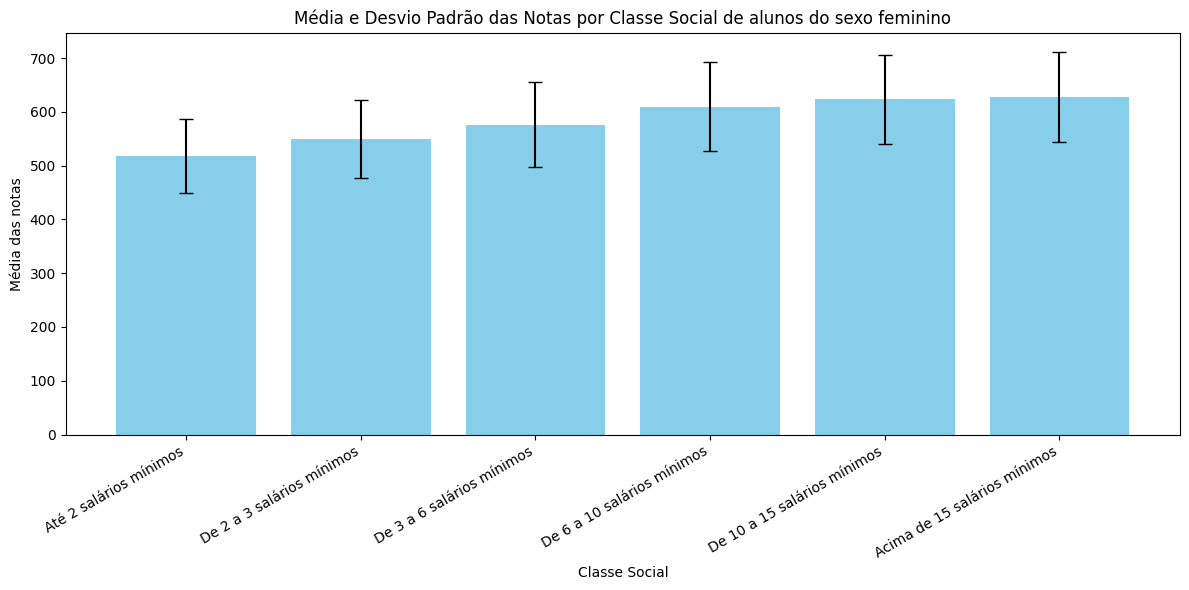

,classe_social,media,mediana,desvio_padrao,variancia,q1,q3,valor_minimo,valor_maximo,amplitude,coef_var,ordem
1,Até 2 salários mínimos,517.474914,537.777315,69.073532,4771.152881,480.480000,537.777315,0.00,826.30,826.30,13.348190,1
3,De 2 a 3 salários mínimos,549.341013,537.777315,73.088889,5341.985755,515.940000,590.100000,0.00,836.80,836.80,13.304830,2
4,De 3 a 6 salários mínimos,576.299796,564.240000,79.789635,6366.385927,537.777315,631.780000,57.76,844.52,786.76,13.845161,3
5,De 6 a 10 salários mínimos,609.564911,611.740000,82.536071,6812.203069,537.777315,670.925000,58.52,834.50,775.98,13.540161,4
2,De 10 a 15 salários mínimos,623.482804,629.340000,82.699978,6839.286306,553.560000,686.180000,130.18,831.62,701.44,13.264195,5
0,Acima de 15 salários mínimos,627.401543,635.260000,83.825011,7026.632447,556.155000,690.960000,168.40,850.40,682.00,13.360664,6


In [71]:
analisar_desempenho_por_classe(dataset_mulher, "de alunos do sexo feminino")

Importância das features (agregada):
Feature Q010: 0.1910
Feature num__NU_NOTA_MT: 0.1040
Feature num__NU_NOTA_LC: 0.0931
Feature num__NU_NOTA_CH: 0.0909
Feature num__NU_NOTA_CN: 0.0884
Feature num__NU_NOTA_REDACAO: 0.0607
Feature Q008: 0.0579
Feature num__TP_FAIXA_ETARIA: 0.0407
Feature Q018: 0.0289
Feature num__TP_ANO_CONCLUIU: 0.0244
Feature num__TP_COR_RACA: 0.0242
Feature Q009: 0.0233
Feature Q019: 0.0222
Feature Q011: 0.0213
Feature Q013: 0.0193


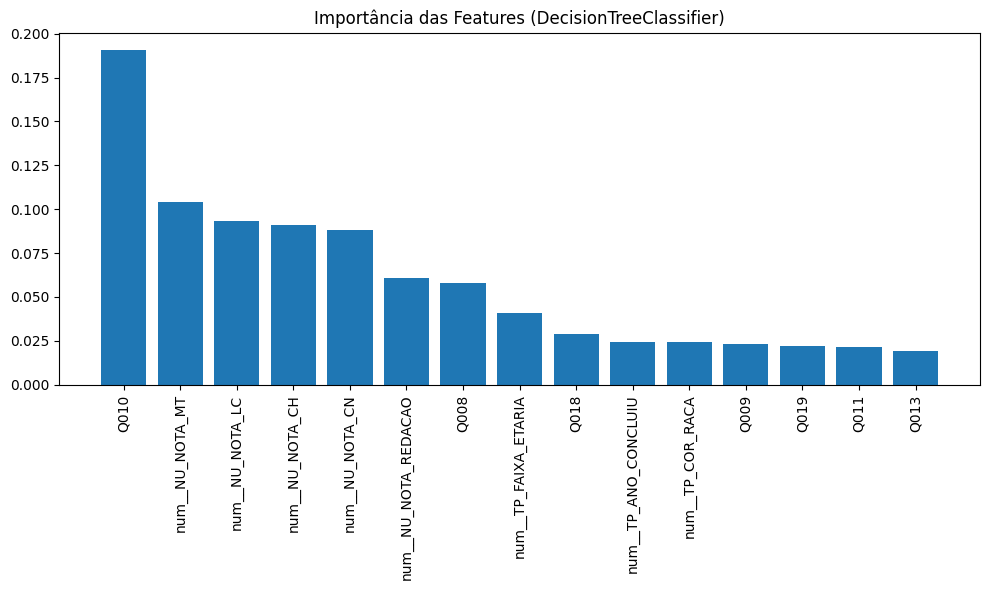

In [49]:
df_importancias_mulher = analisar_importancia_features_agregada(modelo_mulher,clf_mulher, categoricas, top_n=15)

Importância das features (sem agregação):
cat__Q010_A: 0.1823
num__NU_NOTA_MT: 0.1040
num__NU_NOTA_LC: 0.0931
num__NU_NOTA_CH: 0.0909
num__NU_NOTA_CN: 0.0884
num__NU_NOTA_REDACAO: 0.0607
cat__Q008_B: 0.0496
num__TP_FAIXA_ETARIA: 0.0407
num__TP_ANO_CONCLUIU: 0.0244
num__TP_COR_RACA: 0.0242
cat__Q018_B: 0.0209
cat__Q007_A: 0.0151
cat__Q014_A: 0.0127
num__TP_ESTADO_CIVIL: 0.0120
num__TP_ESCOLA: 0.0092


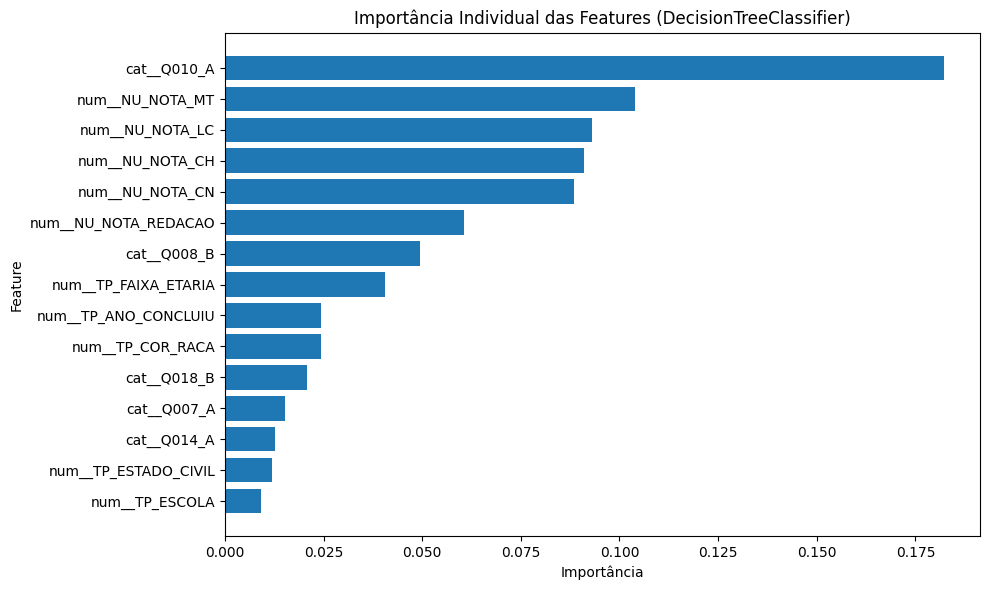

In [47]:
df_importancias_individuais_mulher = analisar_importancia_features(modelo_mulher, clf_mulher, top_n=15)